# Machine Learning analysis

- This is a Python base notebook  

Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

## Imports

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
    
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import (
    classification_report,
    roc_curve,
    RocCurveDisplay,
    roc_auc_score
)

import shap
from pylyrics import clean_text as ct

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Reading the data CSV
Read in the data CSV and store it as a pandas dataframe named `spotify_df`.

In [3]:
spotify_df = pd.read_csv('data/spotify_df_processed.csv')#, index_col = 0 )
spotify_df.head(6)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,emb_sent_758,emb_sent_759,emb_sent_760,emb_sent_761,emb_sent_762,emb_sent_763,emb_sent_764,emb_sent_765,emb_sent_766,emb_sent_767
0,0.0102,0.833,204600,0.434,0.0219,2,0.165,-8.795,1,0.431,...,-0.043803,-0.447969,0.751878,-0.143682,-0.581485,-0.016169,0.619145,0.287845,-0.234614,-0.471101
1,0.0102,0.833,204600,0.434,0.0219,2,0.165,-8.795,1,0.431,...,-0.242343,0.043233,0.199484,0.161576,-0.384538,0.126095,0.462813,0.112398,0.002923,-0.256447
2,0.0102,0.833,204600,0.434,0.0219,2,0.165,-8.795,1,0.431,...,-0.316598,-0.339585,0.321482,0.280396,-0.003586,0.132081,-0.445193,0.301628,-0.287356,-0.504784
3,0.0102,0.833,204600,0.434,0.0219,2,0.165,-8.795,1,0.431,...,0.087176,-0.227342,0.278918,0.479892,-0.431301,0.224406,1.213418,-0.474493,-0.316002,-0.365130
4,0.0102,0.833,204600,0.434,0.0219,2,0.165,-8.795,1,0.431,...,0.117087,-0.418446,-0.040964,0.428880,-0.310667,-0.276378,0.260933,-0.361207,-0.267050,-0.332415
5,0.0102,0.833,204600,0.434,0.0219,2,0.165,-8.795,1,0.431,...,-0.182009,-0.468775,0.299990,0.213028,0.011709,-0.149237,0.507415,0.057419,-0.013157,-0.161389


## Data splitting
Split the data into train and test portions. Remove `song_title`, separate data to `X_train`, `y_train`, `X_test`, `y_test`.

In [4]:
train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["target"]), train_df["target"].astype('category')
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"].astype('category')

In [5]:
# printing the number of observations for train and test sets
print('The number of observations for train set: ', train_df['target'].shape[0])
print('The number of observations for test set: ', test_df['target'].shape[0])

The number of observations for train set:  3831
The number of observations for test set:  958


I split 20% of the observations in the test data and 80% in the train data set. Overall the data set has about 4,000 observations, as it is not a very large data set, I preserved more portion for training.

## Scoring metric

In [6]:
print('The number of observations for positive targe: ', train_df["target"].sum())
print('The number of observations for negative targe: ', len(train_df["target"])-train_df["target"].sum())

The number of observations for positive targe:  1993
The number of observations for negative targe:  1838


Since it is a balanced data set and both positive and negative class are equally balanced, accuracy and precision-recall curves are selected as scoring metric.

In [7]:
scoring_metric = ["accuracy", "roc_auc"]

## Preprocessing and transformations 
Here is different feature types and the transformations I will apply on each feature type. 

| Transformation | Reason                                                                                                                                                                                                                                         | Features                                                                                                                                                                                                |
|---------:|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| OneHotEncoder |All of these features have fixed number of categories. `key` is circulated features like months. | `key`|
| StandardScaler  | Numeric columns needs standardization | `acousticness`, `danceability`, `duration_ms`, `energy`, `instrumentalness`, `liveness`, `loudness`, `mode`, `speechiness`, `tempo`, `time_signature`, `valence`|
| SimpleImputer, StandardScaler     | Analyze lyrics word using `paraphrase-distilroberta-base-v1`,  Numeric feature, processed in feature engineering  | `emb_sent_` |
| none     | The format are as required, represented as category features, processed in feature engineering | `genres_` |
| drop     | Free text column which has low correlation with target.| `song_title` |
| drop     | Replaced by artist genres `genres_`, do not want to be bounded by specific artist| `artist` |

In [8]:
category_feats = ["key"]
none_feats = [col for col in X_train.columns if col.startswith('genres_')]
drop_feats = ['song_title', "artist", 'lyrics'] # Don't want to be bounded by artist


numeric_feats  = list(set(X_train.columns)
            - set(category_feats)
            - set(none_feats)
            - set(drop_feats)
        )

numeric_pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), StandardScaler())


preprocessor = make_column_transformer(
    ("drop", drop_feats),
    (numeric_pipe, numeric_feats),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), category_feats),
    ("passthrough", none_feats)
)
preprocessor.fit(X_train, y_train);

## Baseline model

In [9]:
results = {}

In [10]:
dummy = DummyClassifier()
baseline_pipe = make_pipeline(preprocessor, dummy)
results['dummy'] = mean_std_cross_val_scores(make_pipeline(preprocessor, dummy), X_train, y_train, 
                                             return_train_score=True, scoring=scoring_metric)

In [11]:
pd.DataFrame(results)

,dummy
fit_time,0.138 (+/- 0.015)
score_time,0.054 (+/- 0.003)
test_accuracy,0.520 (+/- 0.001)
train_accuracy,0.520 (+/- 0.000)
test_roc_auc,0.500 (+/- 0.000)
train_roc_auc,0.500 (+/- 0.000)


Accuracy of Dummy classifier depends on class ratio. As we have a balanced data set, the accuracy of Dummy classifier is around 50%.

## Linear models
### Model training - LogisticRegression
First, a linear model is used as a first real attempt. Hyperparameter tuning is also carried out for tuning to explore different values for the regularization hyperparameter. Cross-validation scores along with standard deviation and results summary is shown in below.

In [12]:
#pipe logistic regression
pipe_logisticregression = make_pipeline(preprocessor,
                           LogisticRegression(max_iter=2000, 
                                             random_state=123))

In [13]:
#save in the results logistic regression score
results["LogisticReg"] = mean_std_cross_val_scores(pipe_logisticregression, 
                                                   X_train, 
                                                   y_train, 
                                                   return_train_score=True,
                                                   scoring = scoring_metric,
                                                   n_jobs=-1)
pd.DataFrame(results)

,dummy,LogisticReg
fit_time,0.138 (+/- 0.015),13.436 (+/- 0.415)
score_time,0.054 (+/- 0.003),0.138 (+/- 0.048)
test_accuracy,0.520 (+/- 0.001),0.887 (+/- 0.006)
train_accuracy,0.520 (+/- 0.000),0.972 (+/- 0.002)
test_roc_auc,0.500 (+/- 0.000),0.955 (+/- 0.005)
train_roc_auc,0.500 (+/- 0.000),0.997 (+/- 0.000)


### hyperparameter optimization

We will carry out hyperparameter optimization: C controls the regularization, and class_weight hyperparameter for tackling class imbalance. 

In [14]:
#parameters for logistic regression
param_dist_lg = {'logisticregression__C': np.linspace(2, 3, 6),
                 'logisticregression__class_weight': ['balanced', None]}

#randomized search to find the best parameters
random_search_lg = RandomizedSearchCV(
    pipe_logisticregression, 
    param_dist_lg,
    n_jobs=-1,
    return_train_score=True,
    scoring = scoring_metric,
    refit='accuracy',
    random_state=123
)

In [15]:
random_search_lg.fit(X_train, y_train)
print("Best parameter values are:", random_search_lg.best_params_)
print("Best cv score is:", random_search_lg.best_score_)

Best parameter values are: {'logisticregression__class_weight': None, 'logisticregression__C': 2.8}
Best cv score is: 0.8885437481490055


In [16]:
results['LogisticReg_opt'] = mean_std_cross_val_scores(random_search_lg, 
                                                       X_train, 
                                                       y_train, 
                                                       return_train_score=True,
                                                       scoring = scoring_metric,
                                                       n_jobs=-1) 

In [17]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt
fit_time,0.138 (+/- 0.015),13.436 (+/- 0.415),729.602 (+/- 1.470)
score_time,0.054 (+/- 0.003),0.138 (+/- 0.048),0.126 (+/- 0.062)
test_accuracy,0.520 (+/- 0.001),0.887 (+/- 0.006),0.888 (+/- 0.008)
train_accuracy,0.520 (+/- 0.000),0.972 (+/- 0.002),0.974 (+/- 0.003)
test_roc_auc,0.500 (+/- 0.000),0.955 (+/- 0.005),0.954 (+/- 0.005)
train_roc_auc,0.500 (+/- 0.000),0.997 (+/- 0.000),0.998 (+/- 0.000)


We can see that with optimized hyperparameters, Logistic Regression is doing a bit better. However, it is obvious that we are dealing with overfitting (big gap between test and training scores and the training accuracy is almost 100%). The std is very small ranging in +- 0.01. 

In [18]:
print(
    classification_report(
        y_train,
        random_search_lg.predict_proba(X_train)[:, 1] > 0.5,
        target_names=["0", "1"],
    )
)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1838
           1       0.97      0.97      0.97      1993

    accuracy                           0.97      3831
   macro avg       0.97      0.97      0.97      3831
weighted avg       0.97      0.97      0.97      3831



Area under the curve (AUC): 0.997


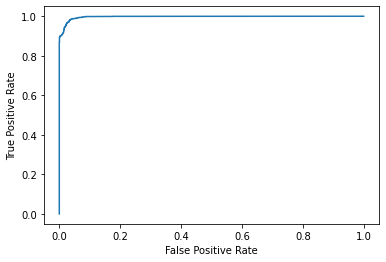

In [19]:
fpr, tpr, _ = roc_curve(
    y_train,
    random_search_lg.predict_proba(X_train)[:, 1],
    pos_label=random_search_lg.classes_[1],
)
print(
    "Area under the curve (AUC): {:.3f}".format(
        roc_auc_score(y_train, random_search_lg.predict_proba(X_train)[:, 1])
    )
)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

We have high score in AUC and classification report, which means our prediction model performance is good.

### Model interpretation on Training set

Most important features are listed in below.

In [20]:
col_name_pp_all = [
    *numeric_feats,
    *random_search_lg.best_estimator_.named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names_out(),
    *none_feats
]

data = {
    "Importance": random_search_lg.best_estimator_.named_steps[
        "logisticregression"
    ].coef_[0],
}
feat_importance = pd.DataFrame(data=data, index=col_name_pp_all).sort_values(
    by="Importance", ascending=False
)

feat_importance_200 = pd.concat([feat_importance[0:100], feat_importance[-100:]])
feat_importance_200["rank"] = feat_importance_200["Importance"].rank(ascending=False)
feat_importance_200["side"] = np.where(
    feat_importance_200["Importance"] > 0, "pos", "neg"
)
feat_importance_200

,Importance,rank,side
genres_escape room,1.945204,1.0,pos
genres_chillwave,1.834105,2.0,pos
genres_moombahton,1.747695,3.0,pos
genres_alternative hip hop,1.667970,4.0,pos
genres_motown,1.571681,5.0,pos
...,...,...,...
genres_neo soul,-1.443566,196.0,neg
genres_pop edm,-1.803435,197.0,neg
genres_post-teen pop,-1.932468,198.0,neg
genres_korean pop,-1.965004,199.0,neg


Most of the important features are determined by `genres`. Excluding all the features from artist, the other important features are `key`, `danceability` and `duration`. However, the ranking of importance are pretty low, starting from #423.

In [21]:
feat_importance_reset = feat_importance.reset_index()
feat_importance_reset[feat_importance_reset['index'].str.match('^(?![genres])')]

,index,Importance
17,key_4,1.274235
36,loudness,0.948385
41,key_9,0.912684
50,danceability,0.862934
62,key_10,0.789978
114,key_7,0.593926
119,key_5,0.579661
131,instrumentalness,0.537758
132,tempo,0.524994
391,valence,0.198514


In [22]:
import altair as alt

base = (
    alt.Chart(feat_importance_200.reset_index())
    .mark_bar()
    .encode(
        x=alt.X(
            "index",
        ),
        y="Importance:Q",
        color="side",
    )
    .properties(height=200, width=800, title="Top 200 important features")
)

brush = alt.selection_interval(encodings=["x"])
lower = (
    base.encode(
        x=alt.X(
            "index",
            axis=alt.Axis(labels=False, title="Features"),
            sort=alt.SortField(field="rank", order="ascending"),
        )
    )
    .properties(height=60, width=800, title="Drag the plot in below to zoom")
    .add_selection(brush)
)

upper = base.encode(
    alt.X(
        "index",
        scale=alt.Scale(domain=brush),
        axis=alt.Axis(title=""),
        sort=alt.SortField(field="rank", order="ascending"),
    )
)

upper & lower

alt.VConcatChart(...)

Top 200 most important features are based on genres.

<br><br>

## Non-linear models
### Model training - RandomForestClassifier, XGBClassifier, LGBMClassifier, CatBoostClassifier
Second, four non-linear model are trained aside from the linear model above.  
After that, feature selection and hyperparameter tuning will carried out in later stage. Cross-validation scores along with standard deviation and results summary is shown in below.

In [23]:
# Random Forest pipe
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))

# XGBoost pipe
pipe_xgb = make_pipeline(
    preprocessor,
    XGBClassifier(
        random_state=123, eval_metric="logloss", verbosity=0, use_label_encoder=False
    ),
)

# LGBM Classifier pipe
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))

# Catboost pipe
pipe_catb = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, random_state=123))

models = {
    "RandomForest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LGBM": pipe_lgbm,
    "Cat_Boost": pipe_catb,
}

# summarize mean cv scores in result_non_linear
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [24]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt,RandomForest,XGBoost,LGBM,Cat_Boost
fit_time,0.138 (+/- 0.015),13.436 (+/- 0.415),729.602 (+/- 1.470),3.025 (+/- 0.158),6.629 (+/- 0.337),2.496 (+/- 0.136),43.591 (+/- 0.065)
score_time,0.054 (+/- 0.003),0.138 (+/- 0.048),0.126 (+/- 0.062),0.096 (+/- 0.003),0.072 (+/- 0.003),0.061 (+/- 0.003),0.675 (+/- 0.045)
test_accuracy,0.520 (+/- 0.001),0.887 (+/- 0.006),0.888 (+/- 0.008),0.900 (+/- 0.011),0.944 (+/- 0.007),0.950 (+/- 0.003),0.954 (+/- 0.005)
train_accuracy,0.520 (+/- 0.000),0.972 (+/- 0.002),0.974 (+/- 0.003),0.997 (+/- 0.001),0.997 (+/- 0.001),0.997 (+/- 0.001),0.995 (+/- 0.001)
test_roc_auc,0.500 (+/- 0.000),0.955 (+/- 0.005),0.954 (+/- 0.005),0.960 (+/- 0.002),0.986 (+/- 0.001),0.991 (+/- 0.002),0.991 (+/- 0.002)
train_roc_auc,0.500 (+/- 0.000),0.997 (+/- 0.000),0.998 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


All the non-linear models are overfitting as all the training scores are close to 1. Compared to most of the models, `LGBM` and `Cat_Boost` are two of the most balanced model in performance, it has the highest accuracy and comparatively less overfitting (the gap between train and validation scores is smaller).

Stability of scores is more or less stable, with standard deviation ranging in around 0.06. 

The fit time of `LGBM` is much shorter than `Cat_Boost`, which is important for the model application, therefore, `LGBM` is by far the most suitable model.

### Model interpretation on Training set

Since `feature_importance_` is not supported on the models, `shap` is used to examine the most important features of our best non-linear models. 

In [25]:
pipe_lgbm.fit(X_train, y_train);

In [26]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=col_name_pp_all,
    index=X_train.index,
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


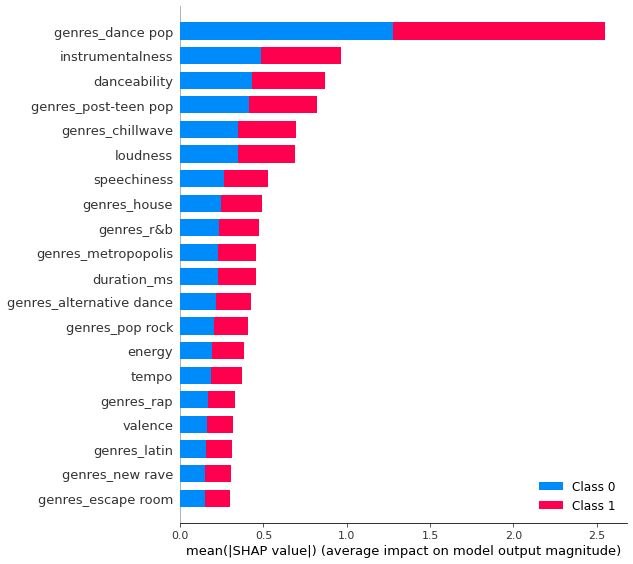

In [27]:
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
shap.summary_plot(train_lgbm_shap_values, X_train_enc, plot_type="bar")

We examined the most important features of `LGBMClassifier` with SHAP methods. Apart from genre, the results suggests that the most important features are `instrumentalness`, `danceability` and `loudness`. Comparing to the linear model, which suggested all `genre_` is the most important features. non-linear model has more diversity.

## Model Averaging
All the models are overfitted. To ease the fundamental trade off, `Averaging` is attempted to see if a higher validation score and shorter fit time can be achieved.

In [28]:
avg_classifiers = {
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm
}

averaging_model = VotingClassifier(
    list(avg_classifiers.items()), voting="soft"
) 

results['averaging'] = mean_std_cross_val_scores(
        averaging_model, X_train, y_train, return_train_score=True, scoring=scoring_metric#, cv=2
    )

In [29]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt,RandomForest,XGBoost,LGBM,Cat_Boost,averaging
fit_time,0.138 (+/- 0.015),13.436 (+/- 0.415),729.602 (+/- 1.470),3.025 (+/- 0.158),6.629 (+/- 0.337),2.496 (+/- 0.136),43.591 (+/- 0.065),14.263 (+/- 0.906)
score_time,0.054 (+/- 0.003),0.138 (+/- 0.048),0.126 (+/- 0.062),0.096 (+/- 0.003),0.072 (+/- 0.003),0.061 (+/- 0.003),0.675 (+/- 0.045),0.278 (+/- 0.010)
test_accuracy,0.520 (+/- 0.001),0.887 (+/- 0.006),0.888 (+/- 0.008),0.900 (+/- 0.011),0.944 (+/- 0.007),0.950 (+/- 0.003),0.954 (+/- 0.005),0.951 (+/- 0.004)
train_accuracy,0.520 (+/- 0.000),0.972 (+/- 0.002),0.974 (+/- 0.003),0.997 (+/- 0.001),0.997 (+/- 0.001),0.997 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001)
test_roc_auc,0.500 (+/- 0.000),0.955 (+/- 0.005),0.954 (+/- 0.005),0.960 (+/- 0.002),0.986 (+/- 0.001),0.991 (+/- 0.002),0.991 (+/- 0.002),0.986 (+/- 0.001)
train_roc_auc,0.500 (+/- 0.000),0.997 (+/- 0.000),0.998 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


According to the result, averaging the models neither help the overfitting issue nor scoring. However, the fit time is slower than `LGBMClassifier`. `LGBMClassifier` is still the best model.

## Results on the test set 

The best performing model `LGBMClassifier` is used on the test data and report test scores. Summary is shown as below. Furthermore, some test predictions and corresponding explanation with SHAP force plots are drawn for further study.

In [30]:
#predictions = pipe_catb.predict(X_test)
print("Test Set accuracy: ", round(pipe_lgbm.score(X_test, y_test), 3))

Test Set accuracy:  0.954


The test set score was similar to the validation score. Therefore, the prediction is promising. 

### Interpretation and feature importances on Test set

In [31]:
# Encoding X_test for SHAP force plot
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=col_name_pp_all,
    index=X_test.index,
)
X_test_enc.shape

(958, 1653)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


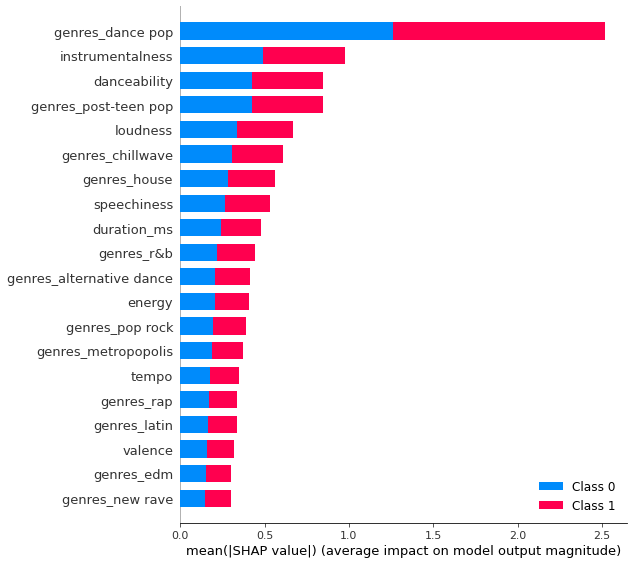

In [32]:
# Create an explainer for X_test_enc
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)
shap.summary_plot(test_lgbm_shap_values, X_test_enc, plot_type="bar")

In [33]:
y_test.iloc[8]

1

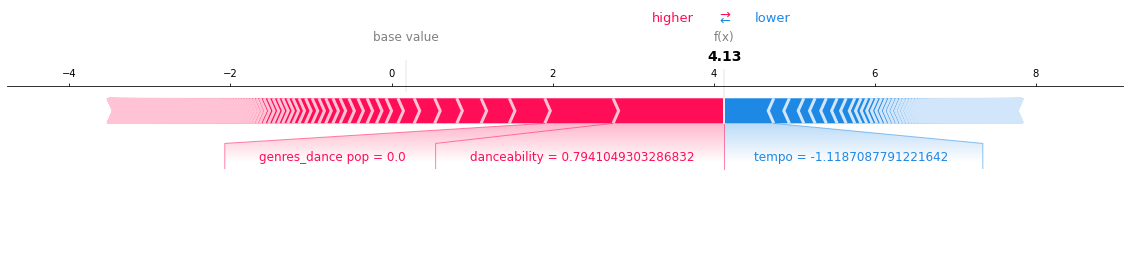

In [34]:
# Force Plot for prediction of 4th row (no_default)
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][8,:],
    X_test_enc.iloc[8,:],
    matplotlib=True,
)

- As seen from the plot, the raw score is much smaller than the base value, which predict accurately as **Like** (class of '1').  
- `danceability` and `genres_dance_pop` are pushing the prediction towards a higher score, and `tempo` is pushing the prediction towards a lower score.

In [35]:
y_test.iloc[10]

0

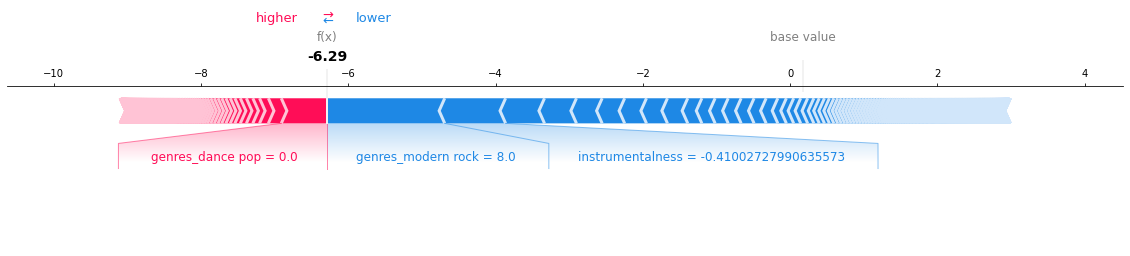

In [36]:
# Force Plot for prediction of 2nd row (no_default)
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][4,:],
    X_test_enc.iloc[4,:],
    matplotlib=True,
)

- As seen from the plot, the raw score is much smaller than the base value, which predict accurately as **Unlike** (class of '0').  
- `genres_dance_pop` is pushing the prediction towards a higher score, and `genres_modern rock` and `instrumentalness` are pushing the prediction towards a lower score.

## Summary of machine learning results 

In [37]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt,RandomForest,XGBoost,LGBM,Cat_Boost,averaging
fit_time,0.138 (+/- 0.015),13.436 (+/- 0.415),729.602 (+/- 1.470),3.025 (+/- 0.158),6.629 (+/- 0.337),2.496 (+/- 0.136),43.591 (+/- 0.065),14.263 (+/- 0.906)
score_time,0.054 (+/- 0.003),0.138 (+/- 0.048),0.126 (+/- 0.062),0.096 (+/- 0.003),0.072 (+/- 0.003),0.061 (+/- 0.003),0.675 (+/- 0.045),0.278 (+/- 0.010)
test_accuracy,0.520 (+/- 0.001),0.887 (+/- 0.006),0.888 (+/- 0.008),0.900 (+/- 0.011),0.944 (+/- 0.007),0.950 (+/- 0.003),0.954 (+/- 0.005),0.951 (+/- 0.004)
train_accuracy,0.520 (+/- 0.000),0.972 (+/- 0.002),0.974 (+/- 0.003),0.997 (+/- 0.001),0.997 (+/- 0.001),0.997 (+/- 0.001),0.995 (+/- 0.001),0.997 (+/- 0.001)
test_roc_auc,0.500 (+/- 0.000),0.955 (+/- 0.005),0.954 (+/- 0.005),0.960 (+/- 0.002),0.986 (+/- 0.001),0.991 (+/- 0.002),0.991 (+/- 0.002),0.986 (+/- 0.001)
train_roc_auc,0.500 (+/- 0.000),0.997 (+/- 0.000),0.998 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


In [38]:
pd.DataFrame(results).to_csv('data/model_results.csv',index=False)

<br><br>

<br><br>